In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import circuit_simulator as cs

In [4]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensornetwork as tn

Calculating overlap with $|0\rangle$ is linear

In [5]:
%timeit cs.sample_process(5)

3.84 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit cs.sample_process(10)

9.88 ms ± 735 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit cs.sample_process(50)

62.7 ms ± 7.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit cs.sample_process(100)

117 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit cs.sample_process(500)

556 ms ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit cs.sample_process(1000)

996 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Calculating overlap with every part is quadratic (although it is possible to speed it up to $O(n \log n)$)

In [6]:
%timeit len(cs.sample_all_qubits(10))

31.7 ms ± 681 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit len(cs.sample_all_qubits(20))

105 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit len(cs.sample_all_qubits(40))

364 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit len(cs.sample_all_qubits(80))

1.44 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit len(cs.sample_all_qubits(160))

5.8 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can speed this up to $O(n\log n)$

In [7]:
%timeit len(cs.sample_all_qubits_faster(10))

22 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit len(cs.sample_all_qubits_faster(20))

48.9 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit len(cs.sample_all_qubits_faster(40))

103 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit len(cs.sample_all_qubits_faster(80))

223 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit len(cs.sample_all_qubits_faster(160))

513 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit len(cs.sample_all_qubits_faster(320))

1.06 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit len(cs.sample_all_qubits_faster(640))

2.5 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Verifying against cirq


In [219]:
import cirq

In [220]:
simulator = cirq.Simulator()

In [226]:
n_qubits = 10

In [227]:
l = cs.sample_ladder(n_qubits)

In [228]:
lp = [cirq.ops.matrix_gates.TwoQubitMatrixGate(g)(cirq.LineQubit(p[0]), cirq.LineQubit(p[1])) for p, g in l]

In [229]:
c2 = cirq.Circuit(lp[:(n_qubits - 1)])
c2 = c2 + cirq.inverse(c2[:-1])

In [230]:
%timeit r = simulator.simulate(c2)

2.75 ms ± 77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [231]:
r = simulator.simulate(c2)

In [237]:
def benchmark_cirq(n_qubits, r):
    probs = []
    for i in range(n_qubits):
        p = r.density_matrix_of([cirq.LineQubit(i)])[0,0]
        probs.append(p)
    return probs
def benchmark_mps(n_qubits, m):
    probs = cs.get_all_probabilities(m.copy())
    return probs
def benchmark_mps_faster(n_qubits, m):
    probs = cs.get_all_probabilities_faster(m.copy())
    return probs

In [233]:
%timeit benchmark_cirq(n_qubits, r)

688 µs ± 7.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [234]:
benchmark_cirq(n_qubits, r)

[(0.79746825+0j),
 (0.8027406+0j),
 (0.79682654+0j),
 (0.7654194+0j),
 (0.7118679+0j),
 (0.6453194+0j),
 (0.5618453+0j),
 (0.44501093+0j),
 (0.1531996+0j),
 (0.36645272+0j)]

In [238]:
%timeit m = cs.compute_mps(n_qubits, l)

7.47 ms ± 94.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [240]:
m = cs.compute_mps(n_qubits, l)

In [241]:
%timeit benchmark_mps(n_qubits, m)

25.4 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [242]:
benchmark_mps(n_qubits, m)

[array(0.79746832),
 array(0.80274074),
 array(0.79682651),
 array(0.76541947),
 array(0.71186805),
 array(0.64531944),
 array(0.56184543),
 array(0.44501091),
 array(0.15319963),
 array(0.36645267)]

In [243]:
%timeit benchmark_mps_faster(n_qubits, m)

15 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [244]:
benchmark_mps_faster(n_qubits, m)

[array(0.79746832),
 array(0.80274074),
 array(0.79682651),
 array(0.76541947),
 array(0.71186805),
 array(0.64531944),
 array(0.56184543),
 array(0.44501091),
 array(0.15319963),
 array(0.36645267)]

# Quick benchmark

In [8]:
# when things are not the same
ps_nosame = []
for x in tqdm(range(2000)):
    ps_nosame.append(cs.sample_all_qubits_faster(50, all_same=False))
ps_nosame = np.array(ps_nosame)

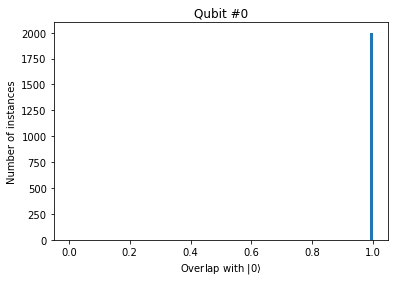

In [9]:
plt.hist(ps_nosame[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

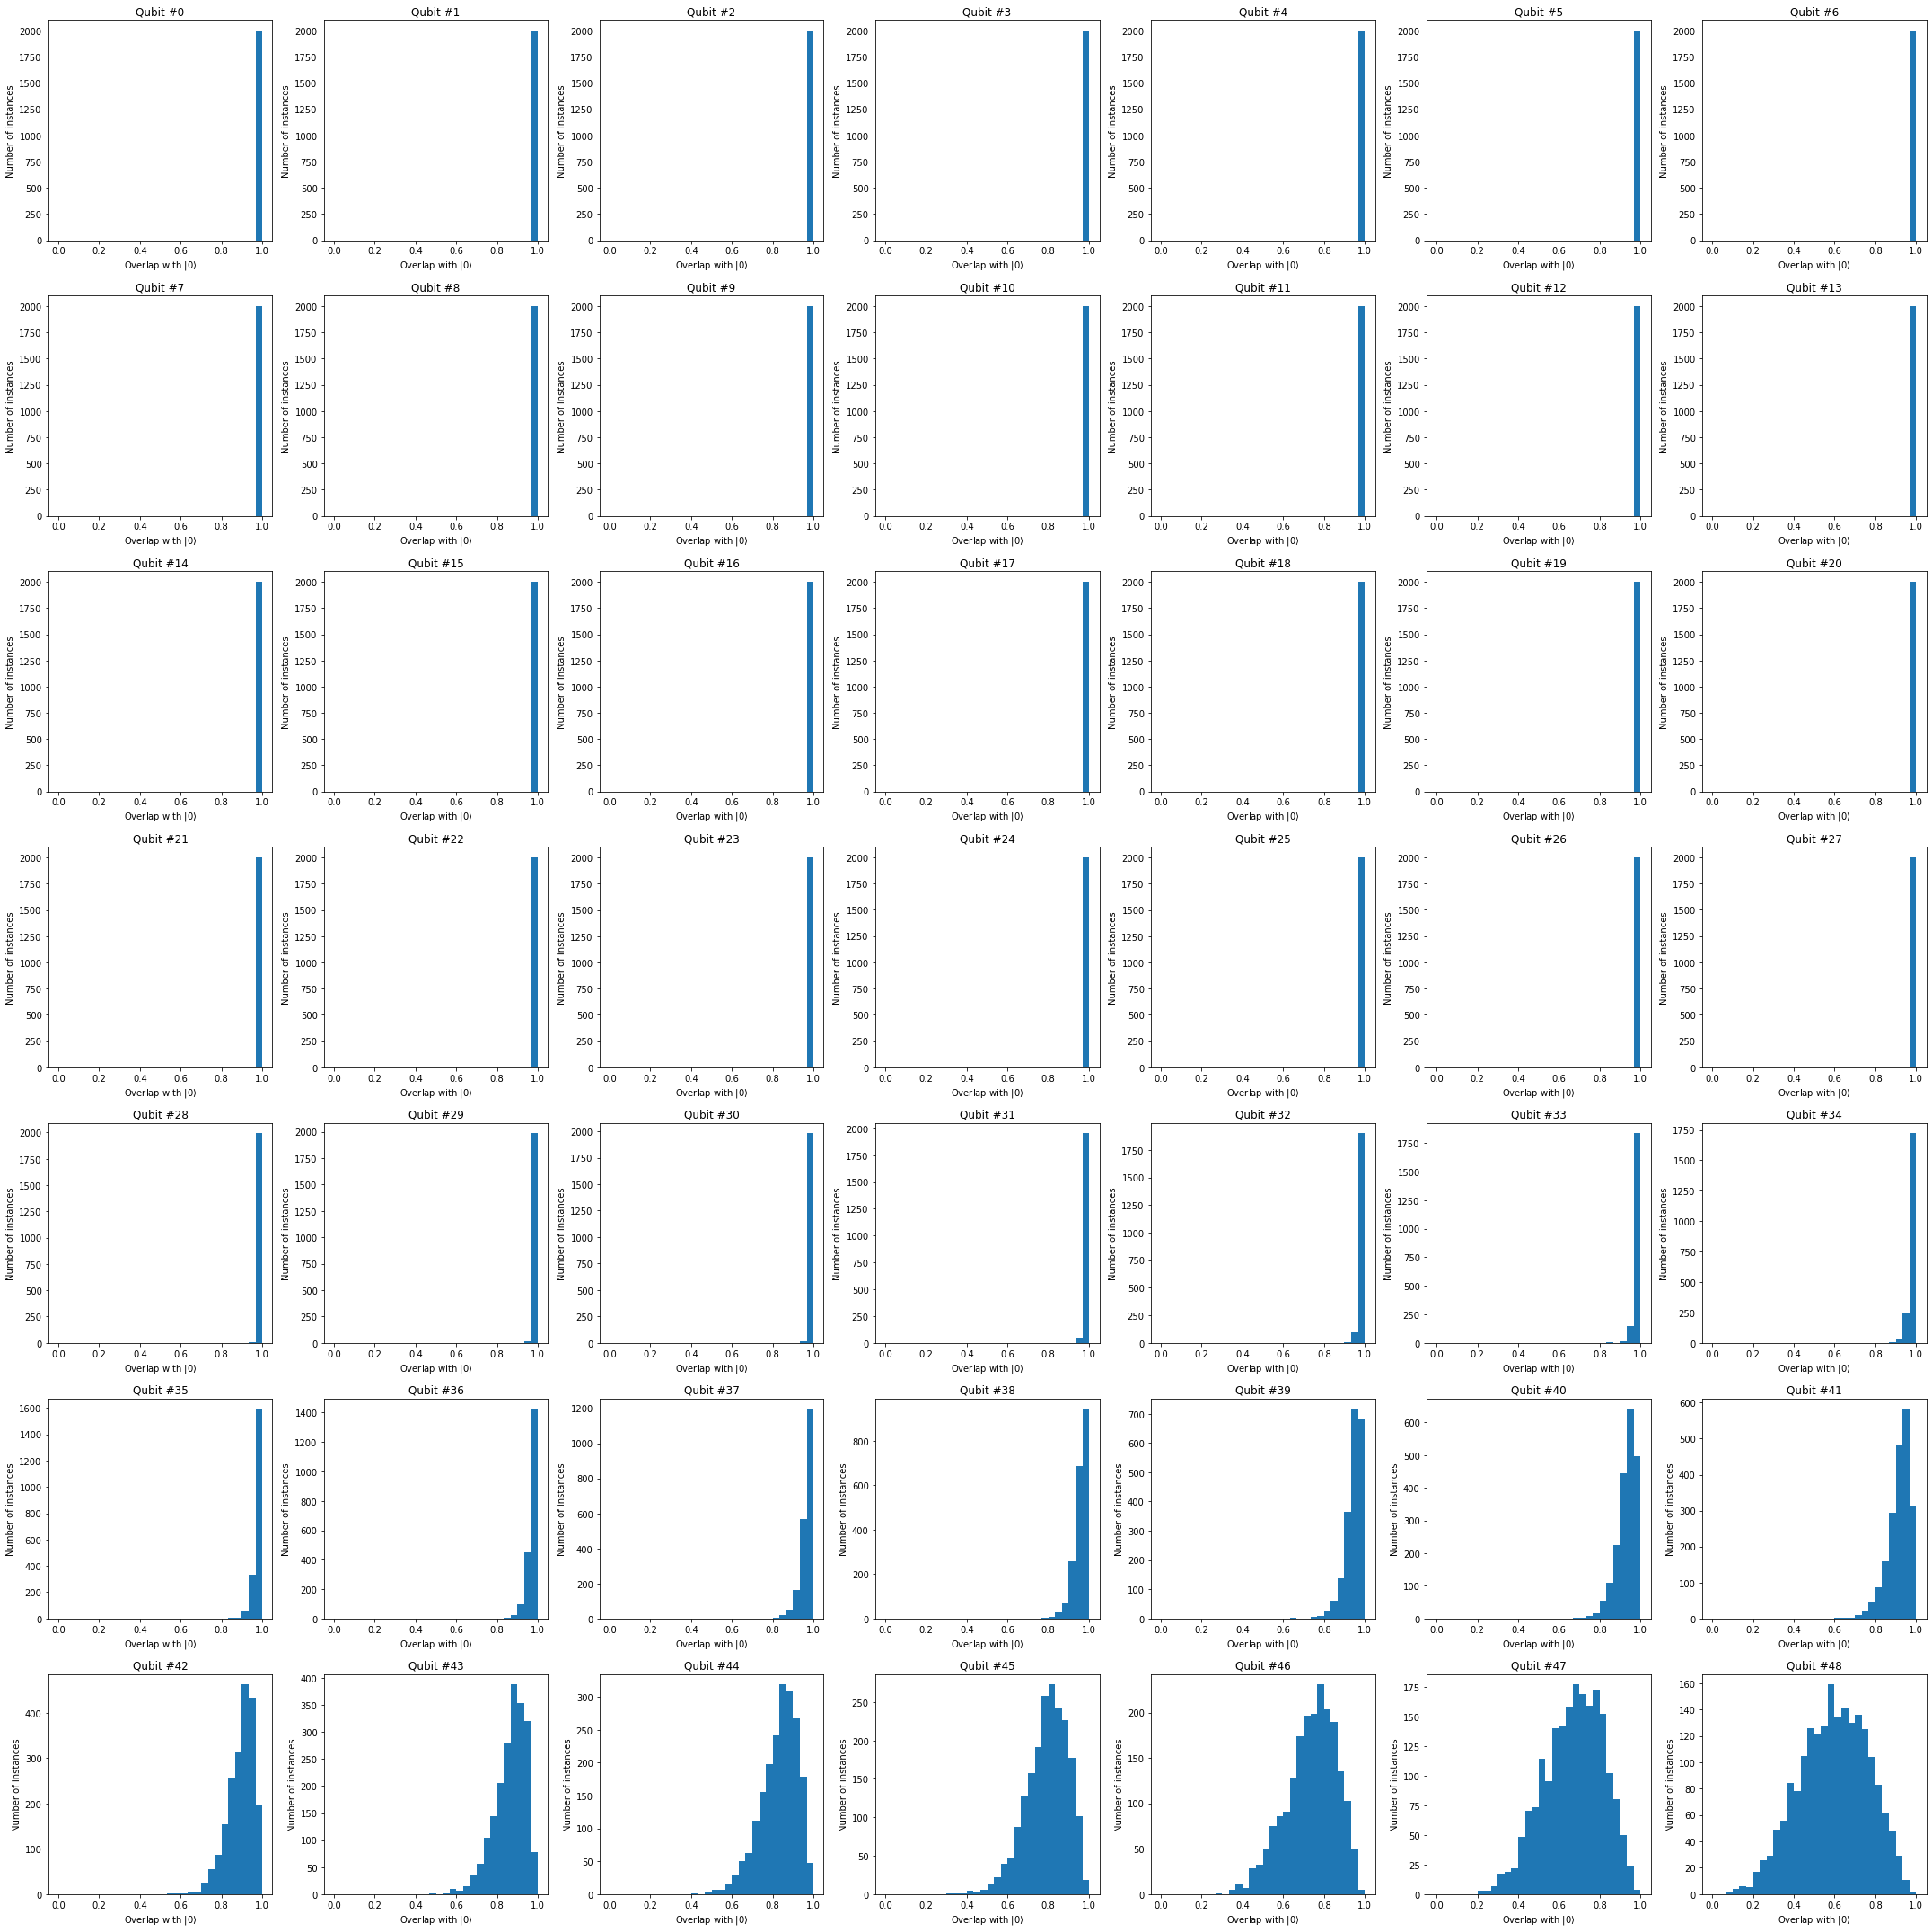

In [10]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps_nosame[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")

fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [12]:
top3 = [cs.sample_top_k(30) for i in tqdm(range(1000))]

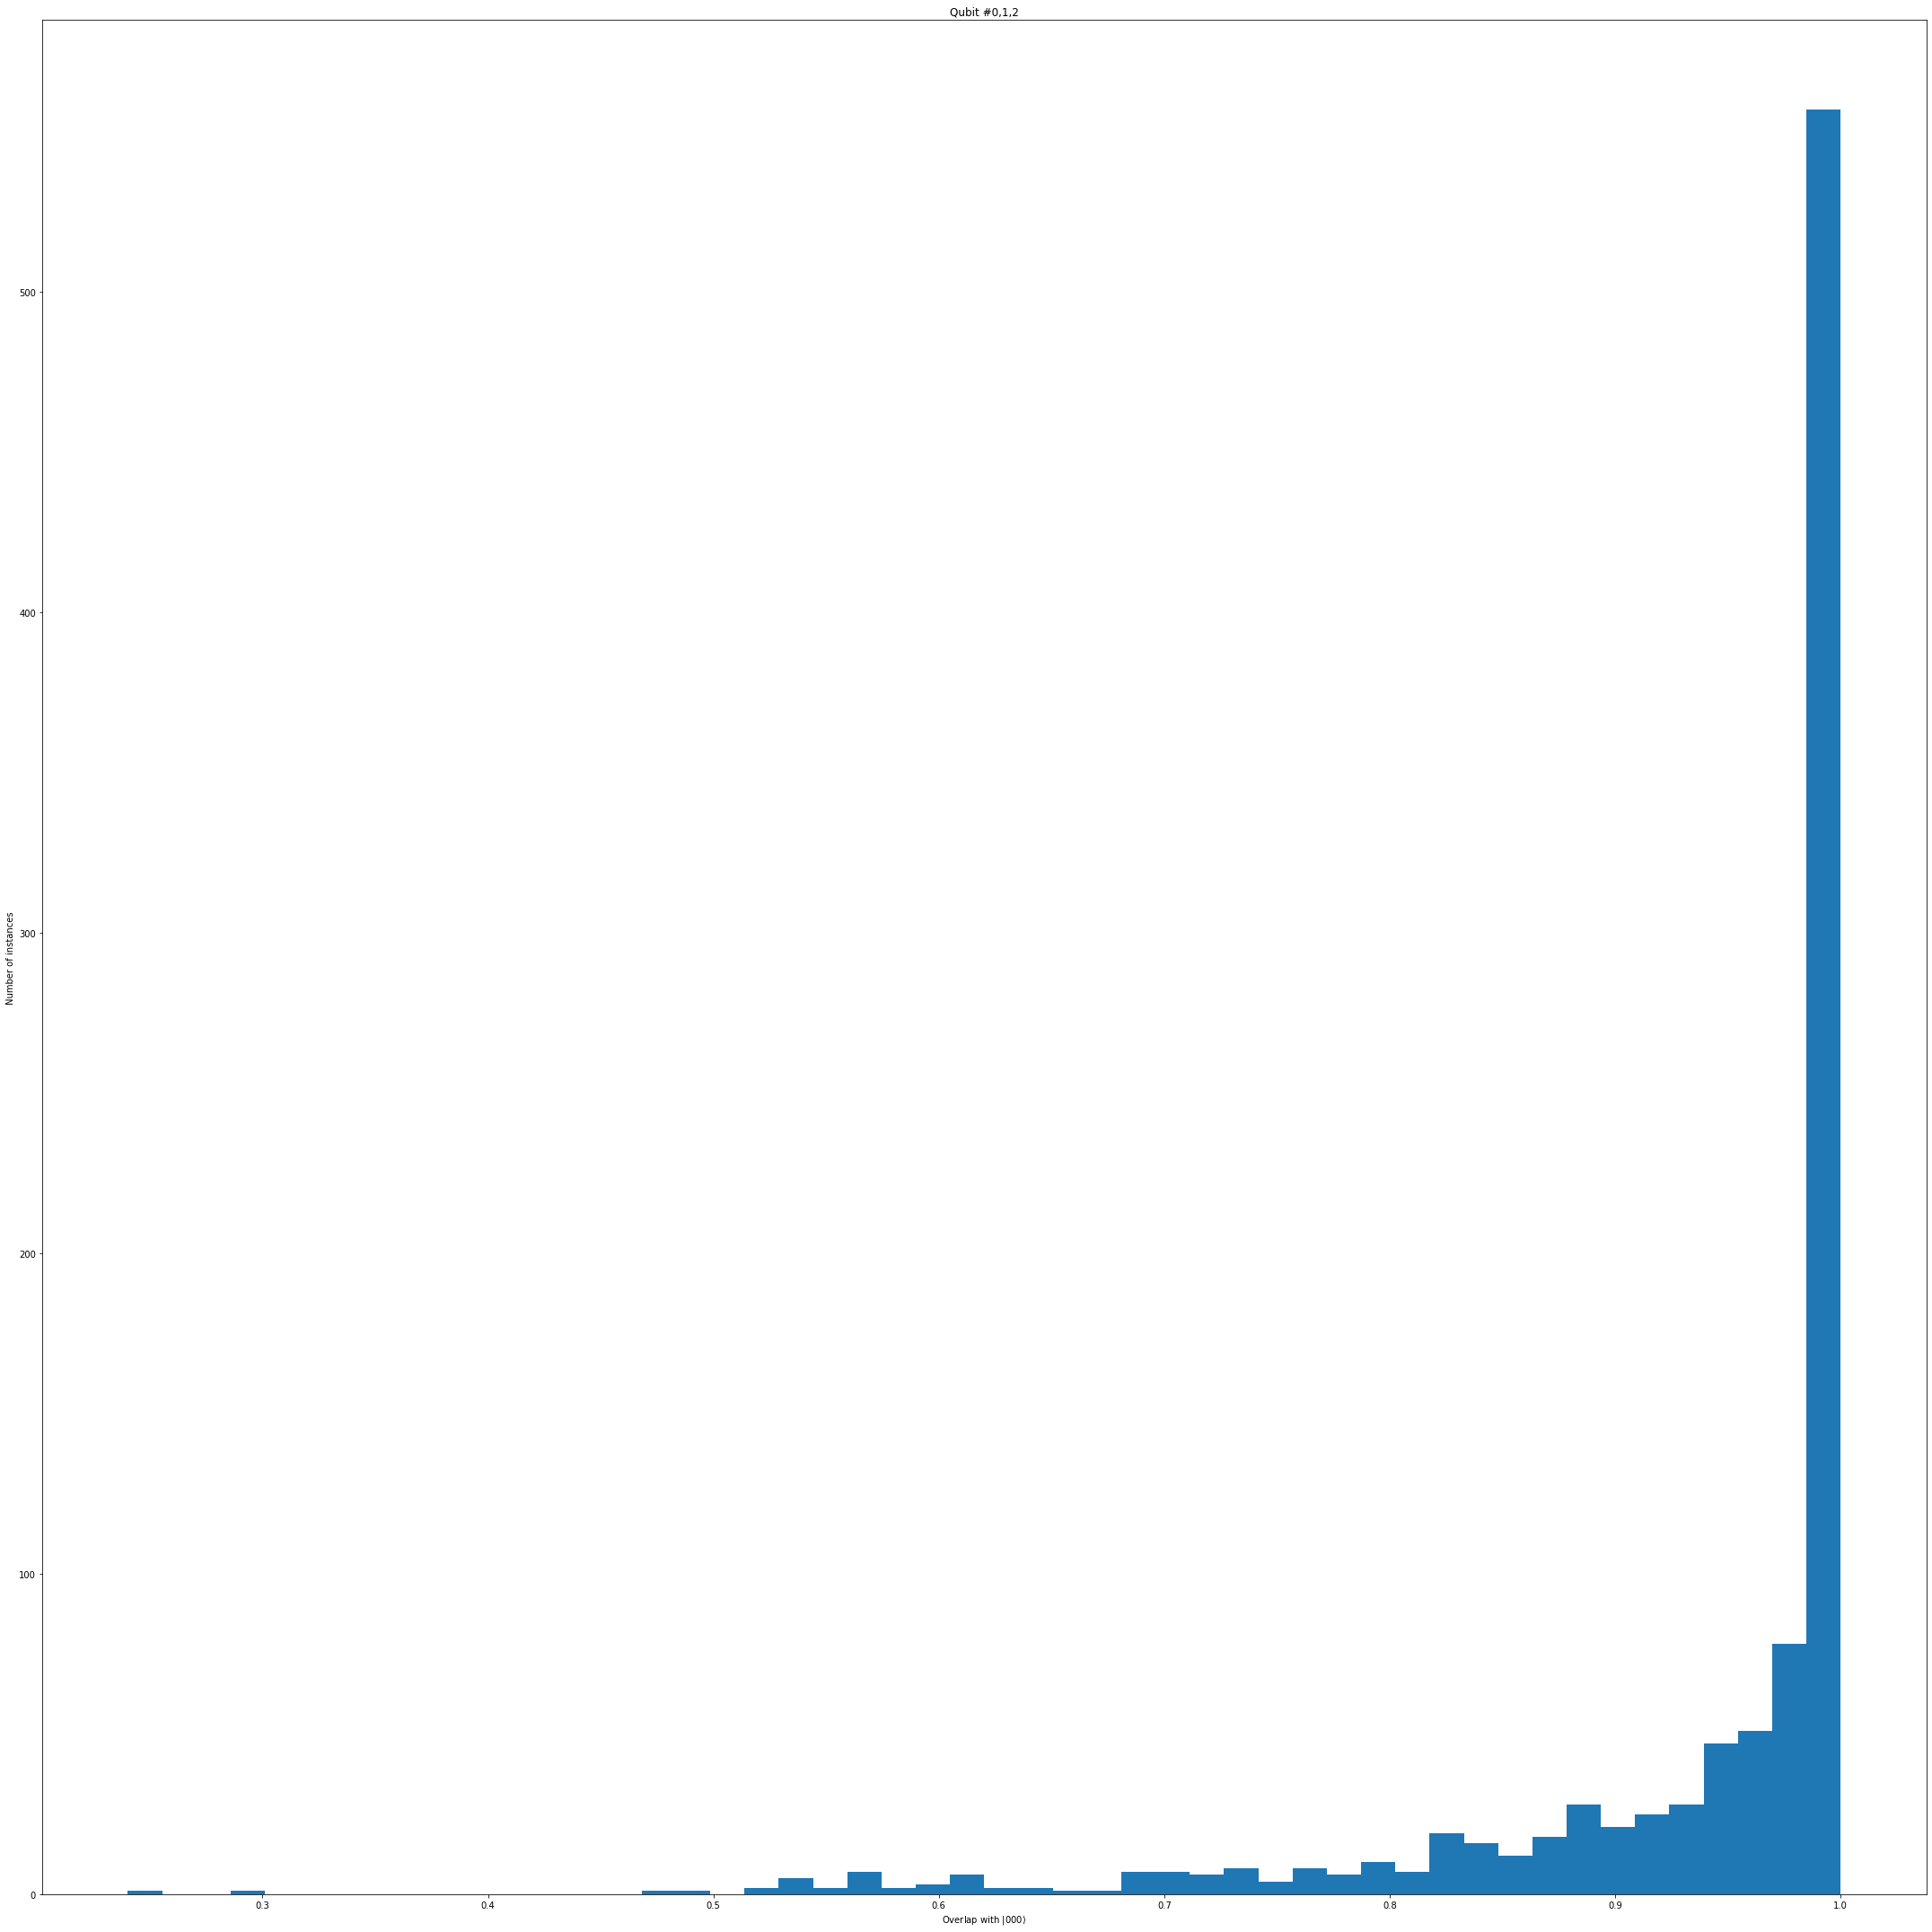

In [13]:
fig=plt.figure(figsize=(30, 30))
t = 0
ax=fig.add_subplot(1,1, 1)
ax.hist(top3, bins = 50)
ax.set_title("Qubit #0,1,2")
ax.set_xlabel(r"Overlap with $|000\rangle$")
ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()
# Note the range

# New ladder

In [14]:
ps = []
for x in tqdm(range(200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(4,1))
ps = np.array(ps)

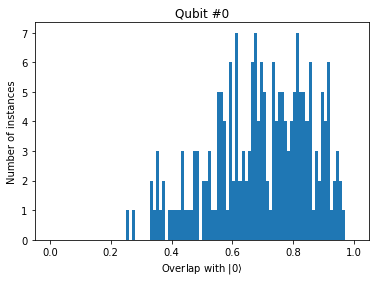

In [15]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

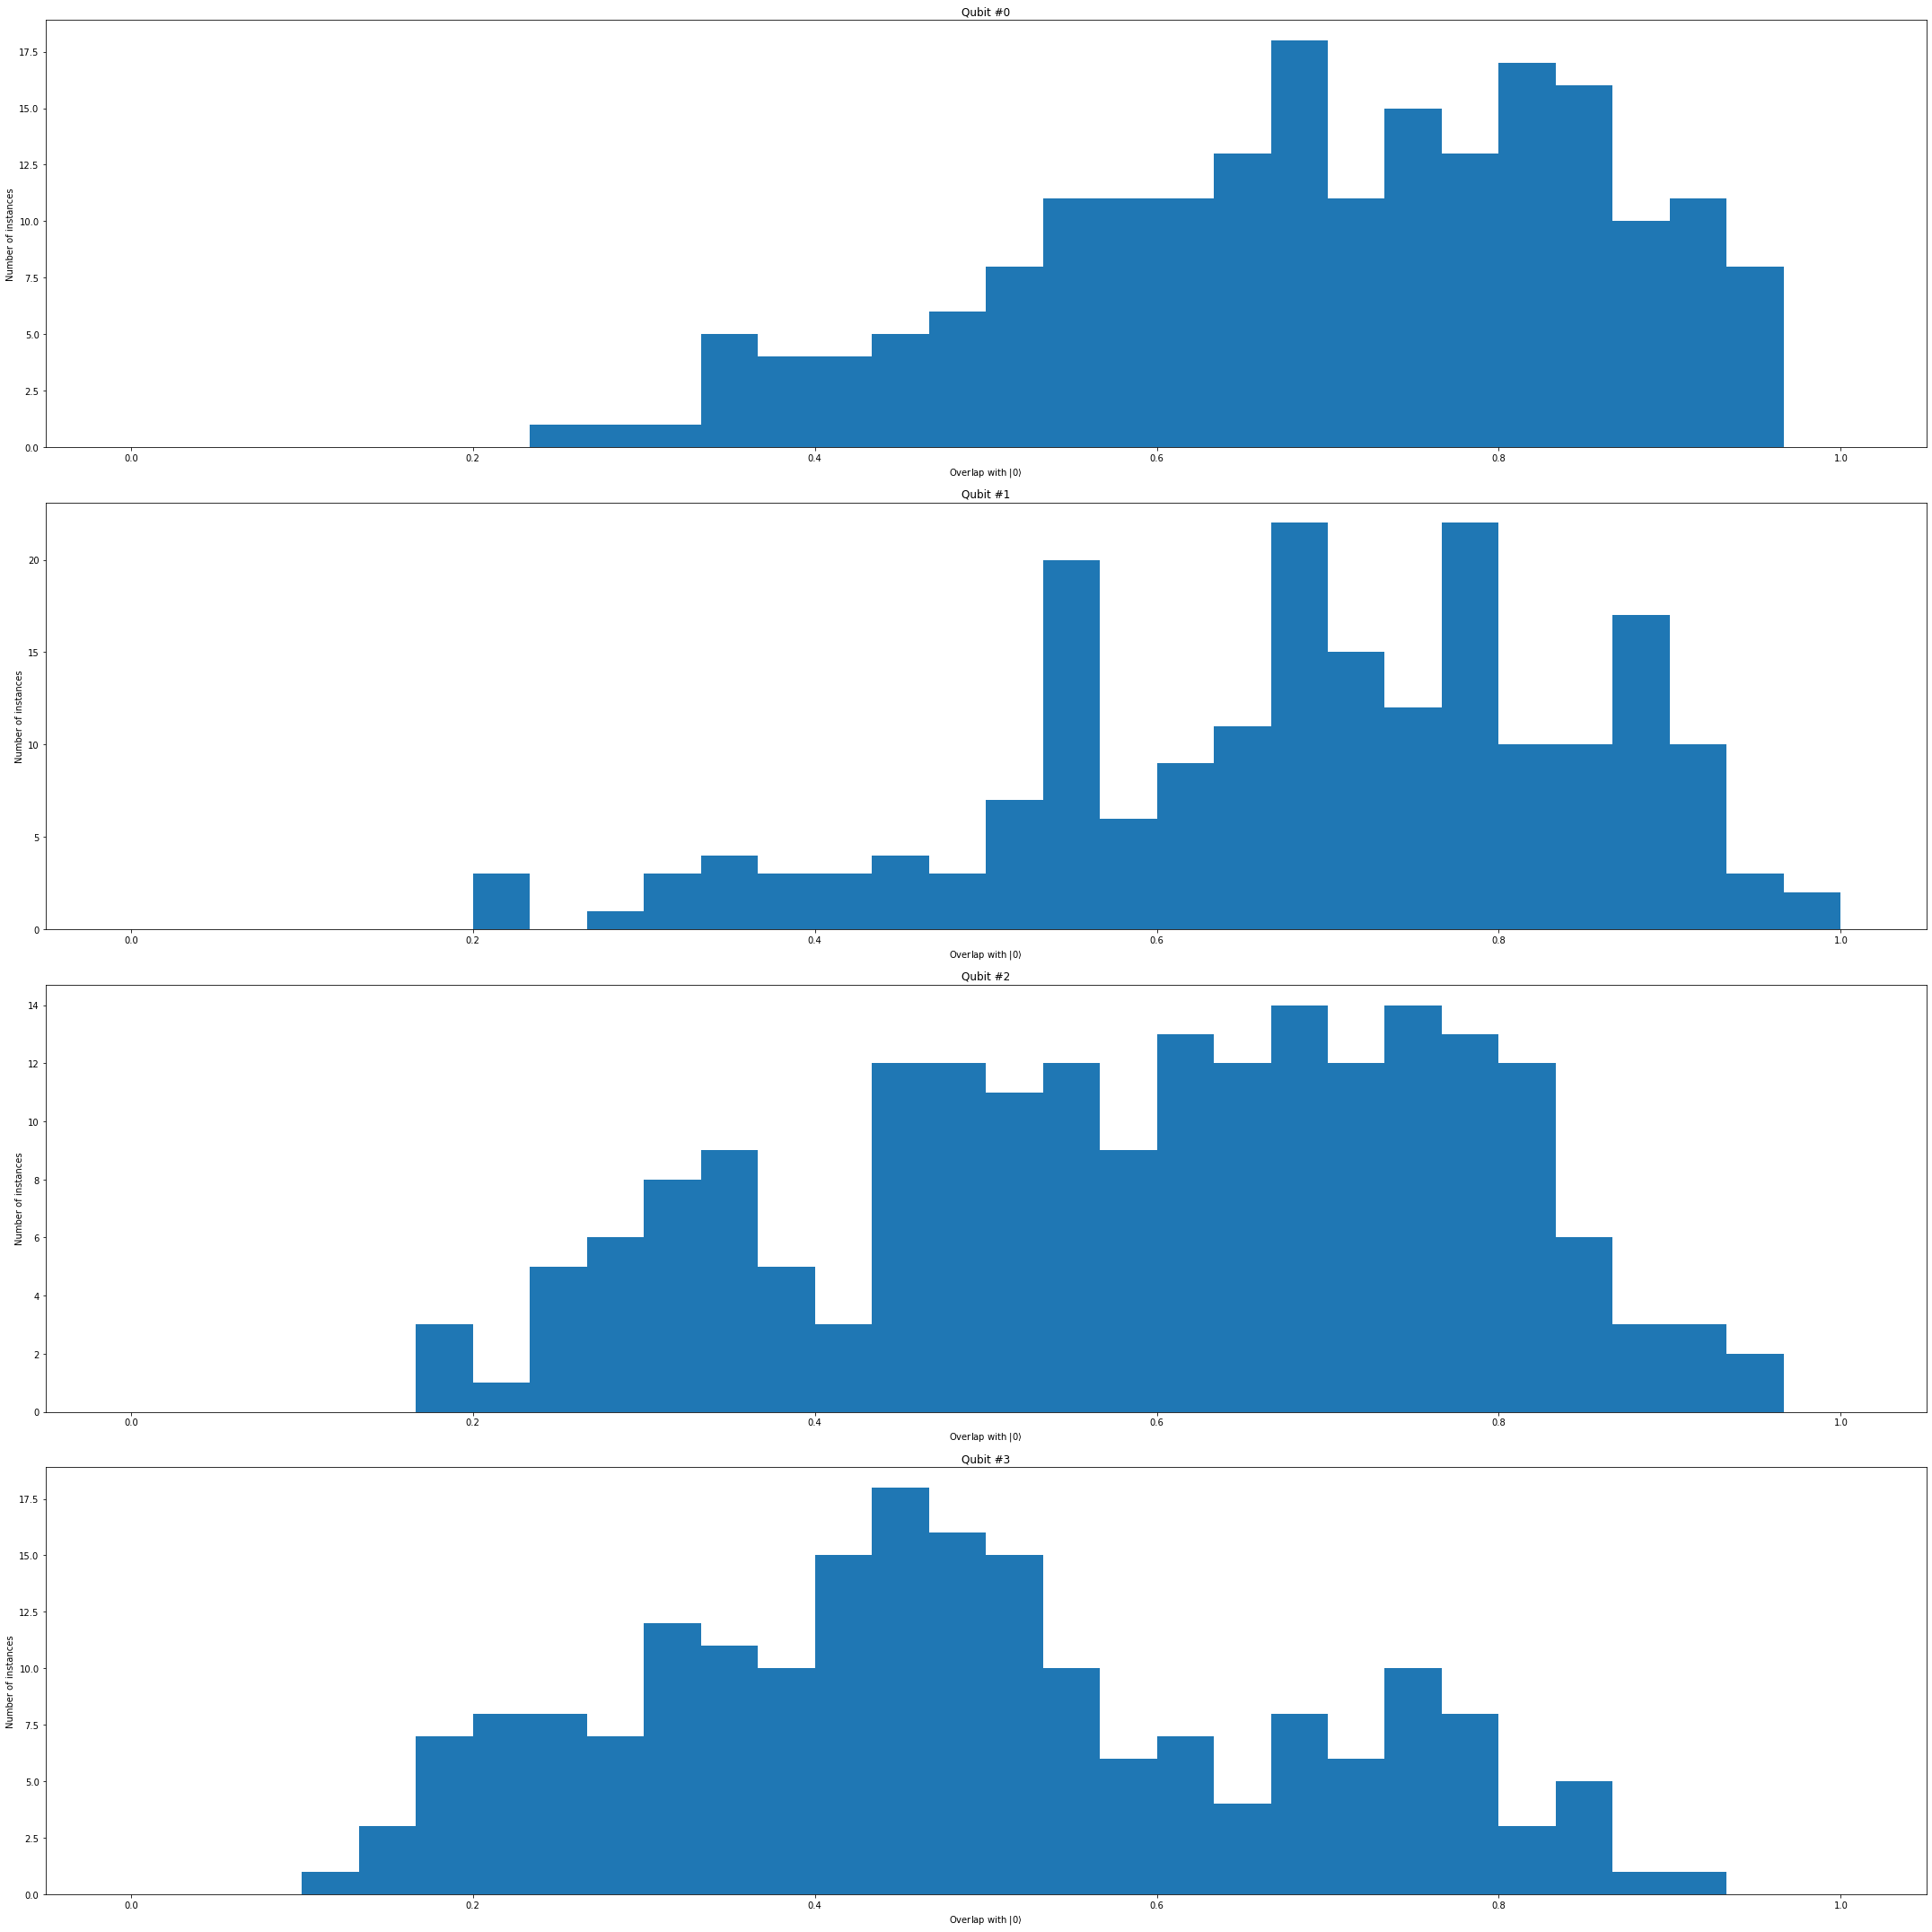

In [16]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(4):
    ax=fig.add_subplot(4,1, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [17]:
ps = []
for x in tqdm(range(200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(3*3+1,2))
ps = np.array(ps)

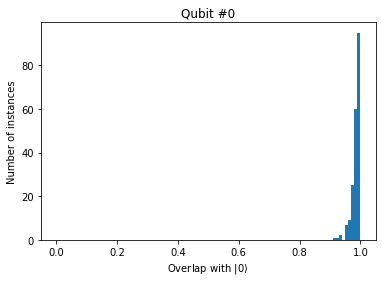

In [18]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

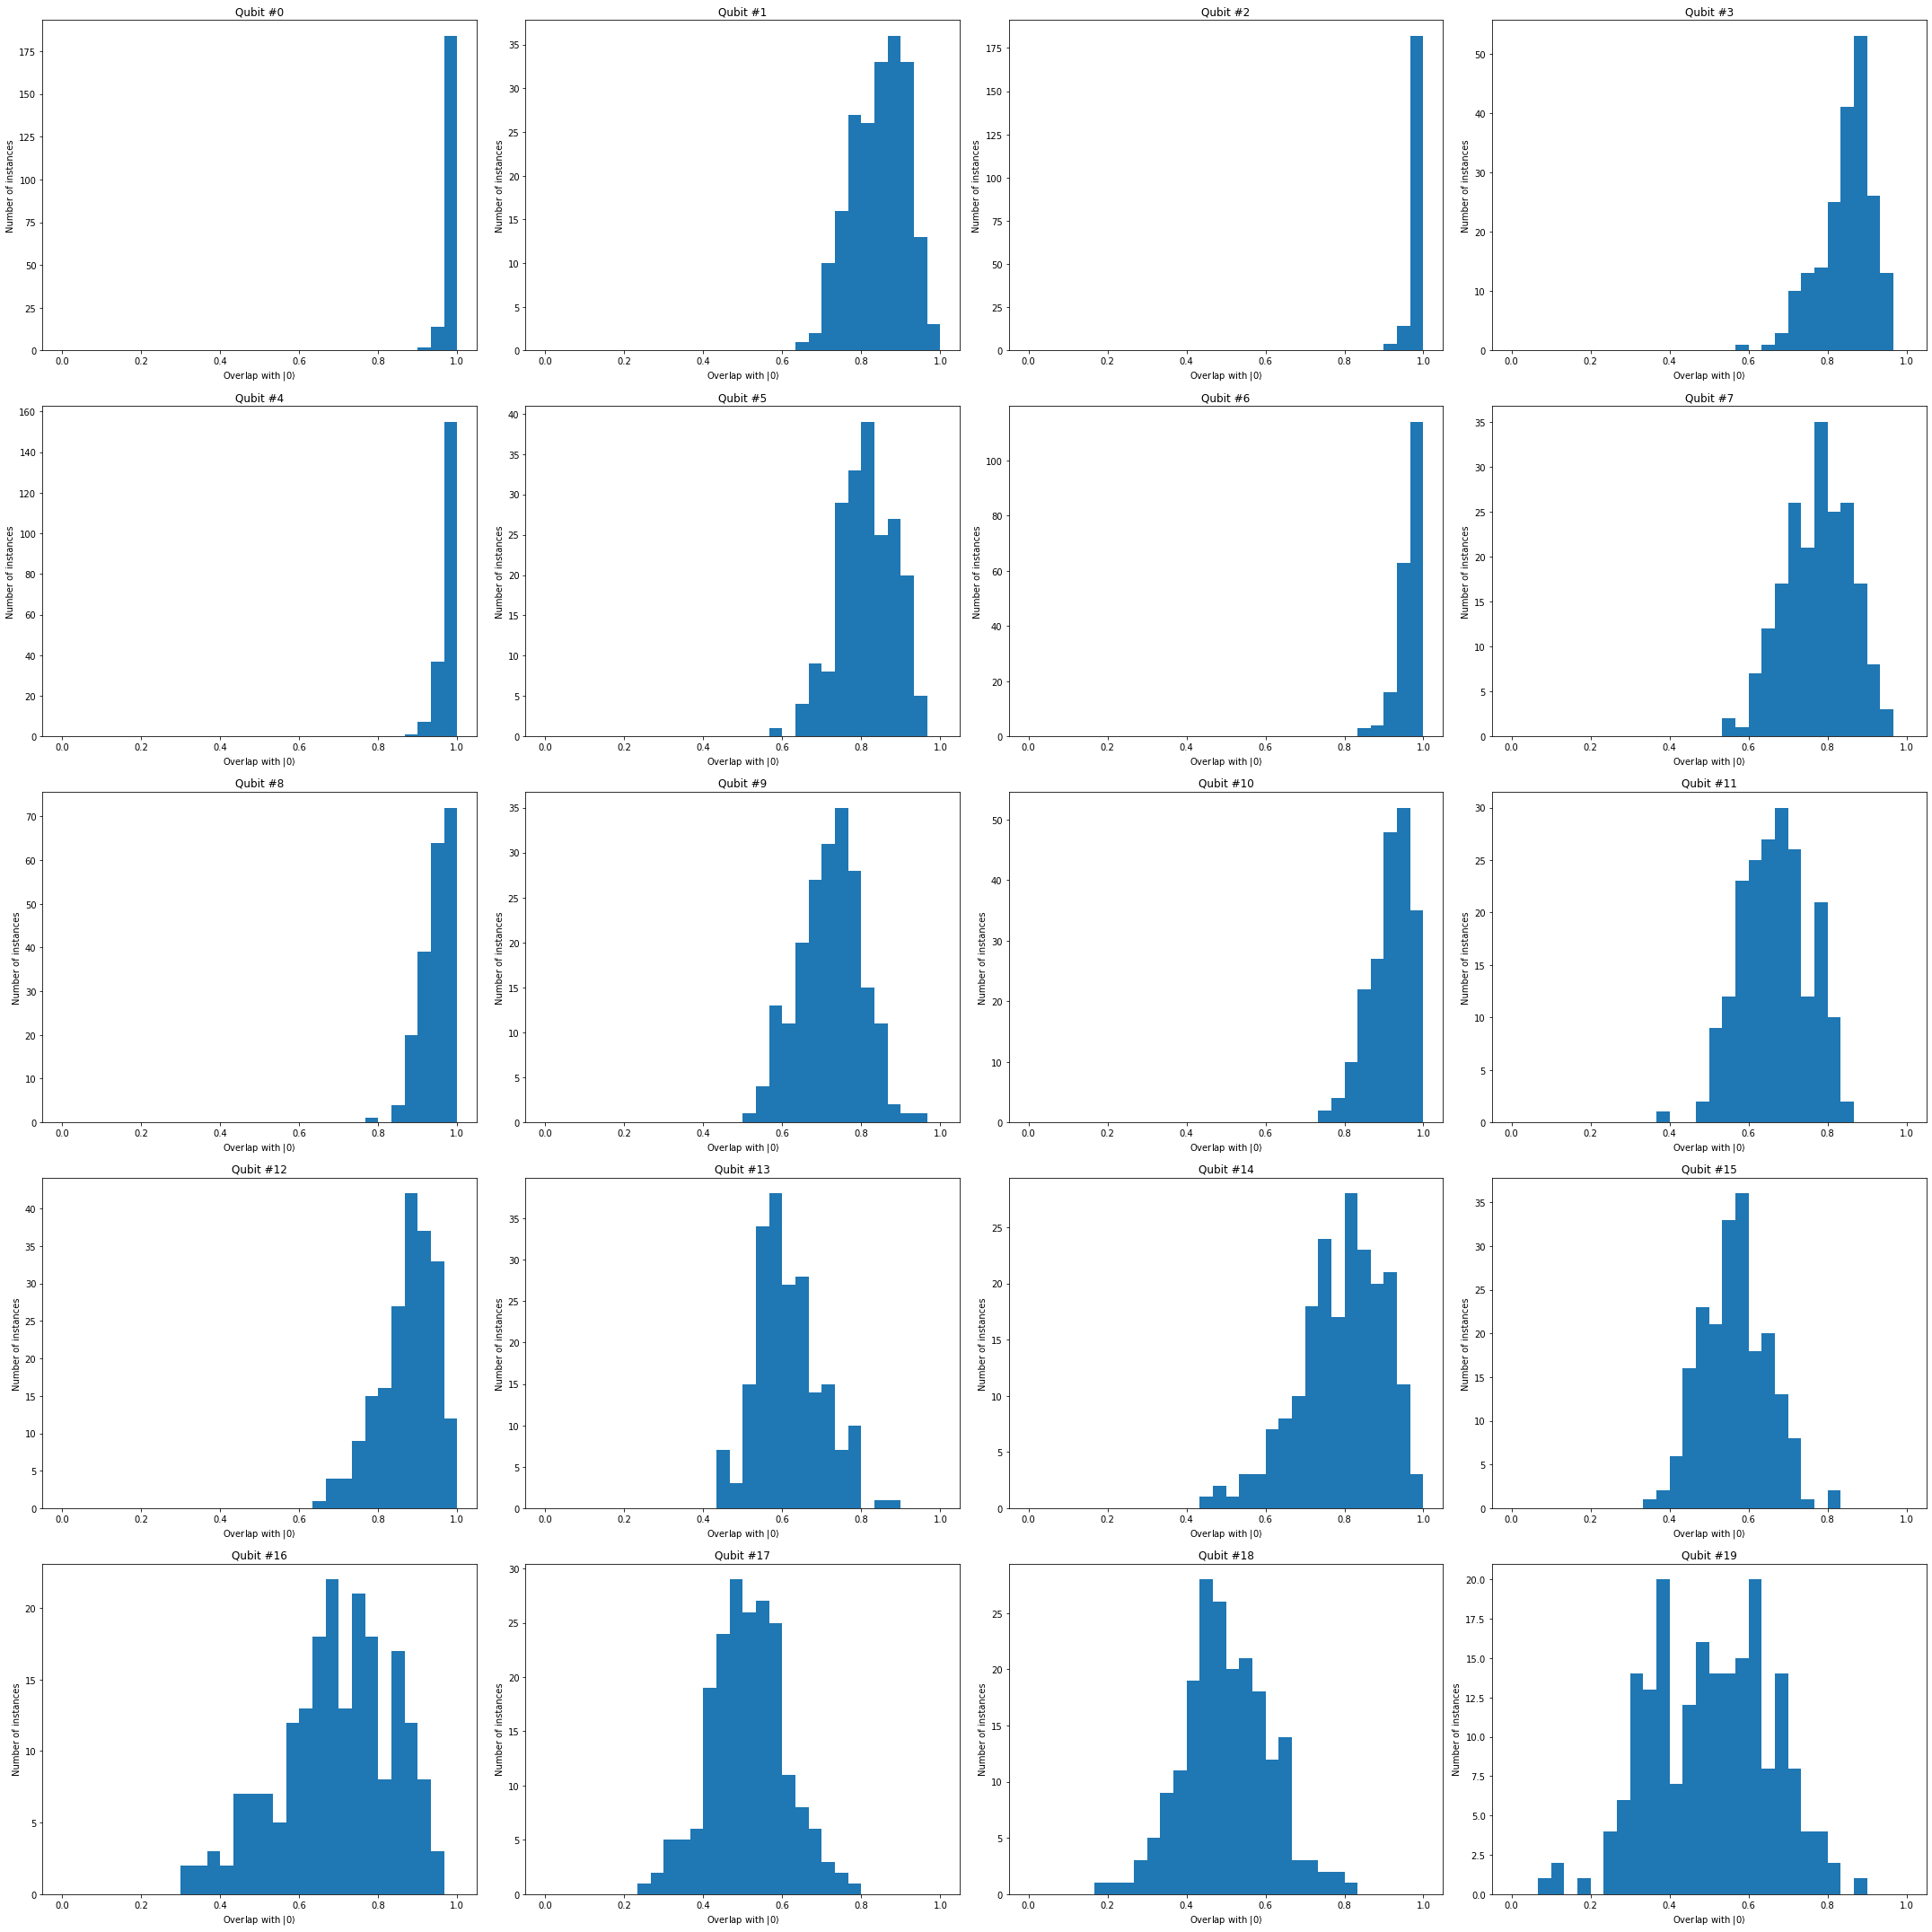

In [19]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(10*2):
    ax=fig.add_subplot(5,4, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [20]:
ps = []

In [21]:
for x in tqdm(range(len(ps),200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(5,3))
ps = np.array(ps)

KeyboardInterrupt: 

In [ ]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

In [ ]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(15):
    ax=fig.add_subplot(5,3, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


# April 6 update

## Eigenvalues (edit: ignore, wrong)

In [ ]:
# not the correct transfer matrix, but it still showcases something we can do
# so leaving the code here for futture reference

In [ ]:
lad = cs.sample_ladder(50, all_same=True)
m = cs.compute_mps(50, lad)

m1 = m.copy(conjugate=False)
m2 = m.copy(conjugate=True)

all_nodes = []
for i in range(m.n_qubits):
    m1.out_edge(i) ^ m2.out_edge(i)

for i in range(m.n_qubits):
    all_nodes.append(m1.nodes[i] @ m2.nodes[i])

for n in all_nodes:
    s = n.tensor.shape
    tf = n.tensor.reshape((s[0]*s[1], s[2]*s[3]))
    eigs = sorted(np.real(np.linalg.eigvalsh(tf)))[::-1]
    print(np.log(np.abs(eigs[0] / eigs[1])))

In [ ]:
# eigenvalues for the diagram showed
eigs = []
for _ in range(10000):
    g = cs.random_unitary_gate(2)
    g = cs.normalize_gate(g)

    t = np.tensordot(np.array([1,0]), g, axes=[0,0])
    o = np.tensordot(t, np.conj(t), axes=[1,1])
    o = np.transpose(o, (1, 2, 3, 0)).reshape(4,4)

    u = sorted(np.linalg.eigvalsh(o))
    eigs.append(u[1])

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.hist(-np.log(eigs), bins = 50)
plt.plot()

In [181]:
um = cs.random_unitary_gate(2)

# u = tn.Node(np.zeros((2,3,4,5)), axis_names = ['a','b','c','d'])

In [194]:
def get_op_from_matrix(um):
    if len(um.shape) == 4:
        u = tn.Node(um, axis_names = ['a','b','c','d'])
    else:
        u = tn.Node(cs.normalize_gate(um), axis_names = ['a','b','c','d'])
    uc = tn.conj(u,axis_names = ['ac','bc','cc','dc'])

    u['c'] ^ uc['cc']
    # u[3] ^ uc[3]

    m = tn.Node(np.array([1,0]))
    m[0] ^ u['a']

    mc = tn.Node(np.array([1,0]))
    mc[0] ^ uc['ac']


    n = m @ u


    nc = mc @ uc

    t = n @ nc 
    return t

# Quick benchmark

In [ ]:
# Similar code to above, but with the new definitions for sampling

In [49]:
ps = []
for x in tqdm(range(2000)):
    ps.append(cs.sample_all_qubits_faster(50))
ps = np.array(ps)

In [86]:
# when things are not the same
ps_nosame = []
for x in tqdm(range(2000)):
    ps_nosame.append(cs.sample_all_qubits_faster(50, all_same=False))
ps_nosame = np.array(ps_nosame)

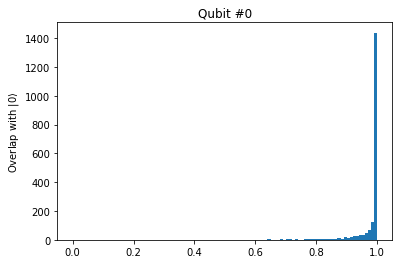

In [50]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

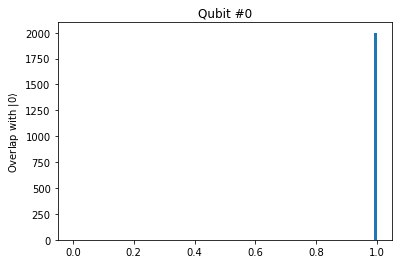

In [87]:
plt.hist(ps_nosame[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

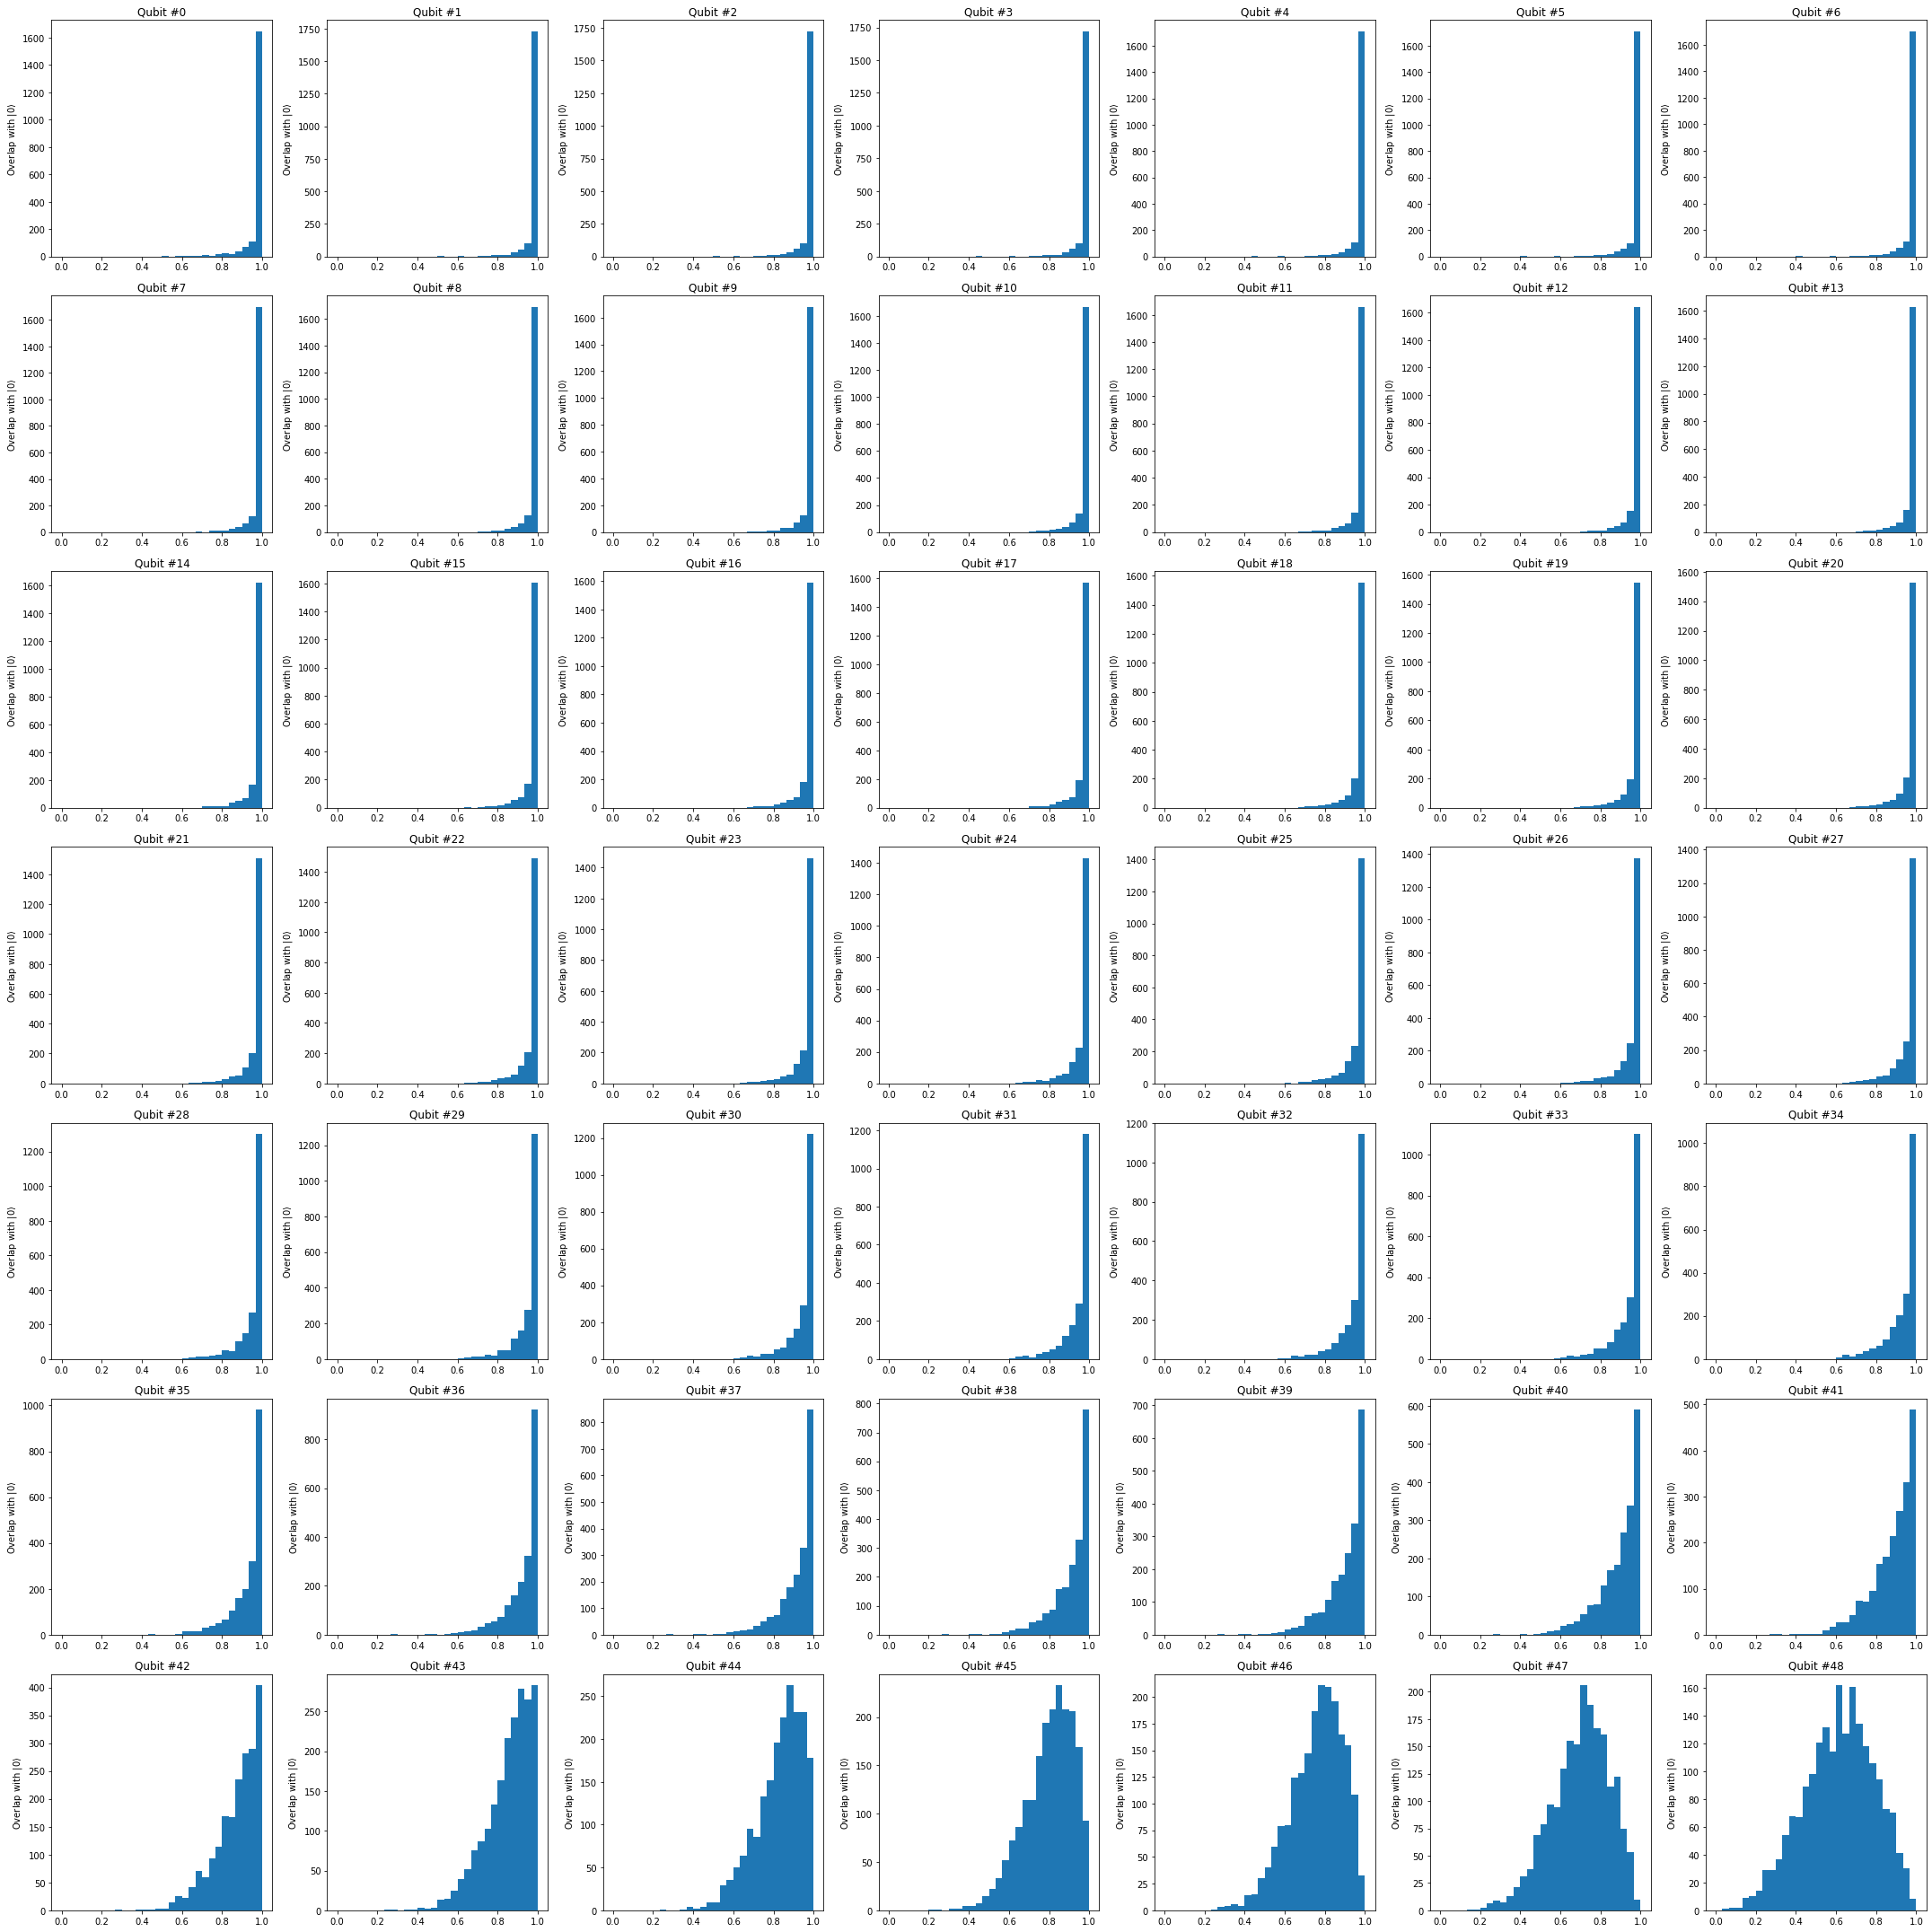

In [51]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
    
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


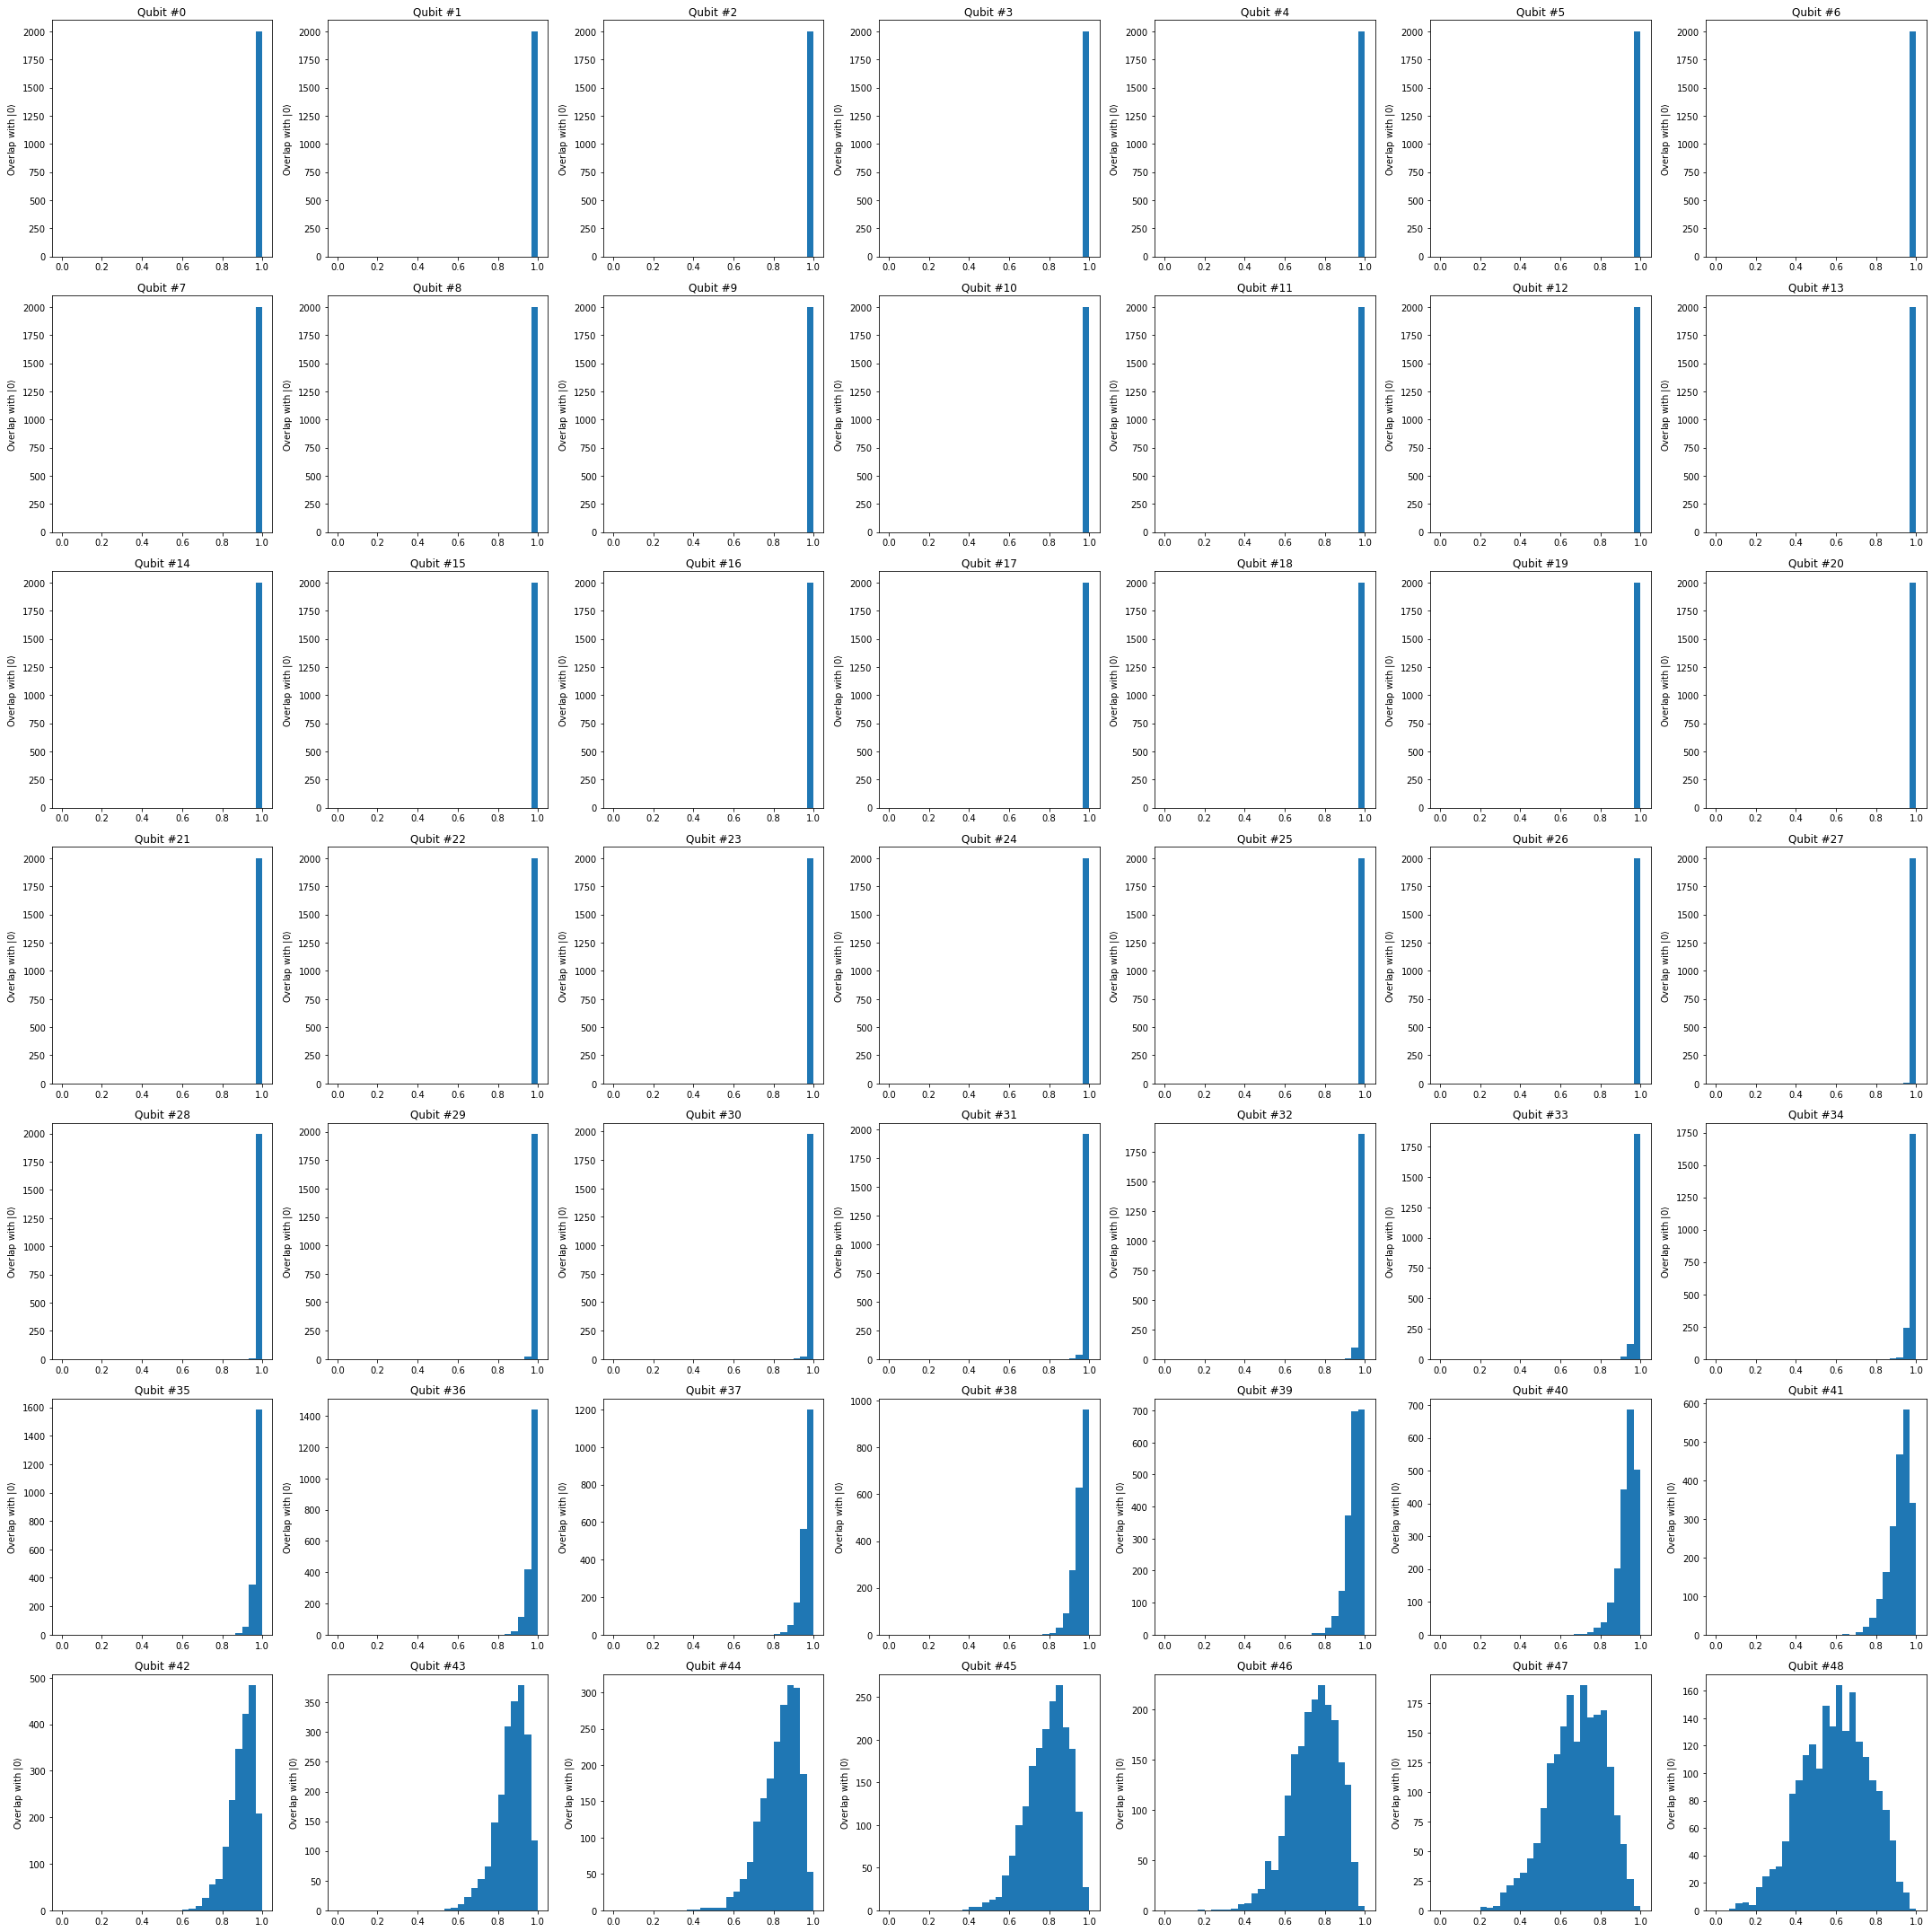

In [88]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps_nosame[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


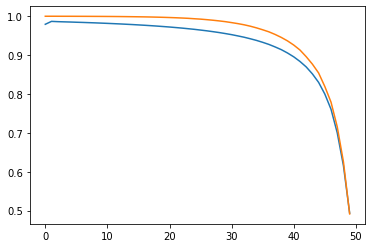

In [89]:
#blue is mean, orange is median
plt.plot(np.mean(ps,axis=0), label='Mean')
plt.plot(np.median(ps,axis=0), label='Median')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Mean/median overlap")
plt.title("Same random gate")
plt.show()

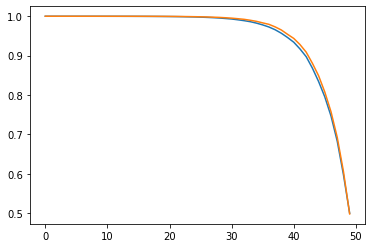

In [90]:
plt.plot(np.mean(ps_nosame,axis=0), label='Mean')
plt.plot(np.median(ps_nosame,axis=0), label='Median')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Mean/median overlap")
plt.title("IID random gate")
plt.show()

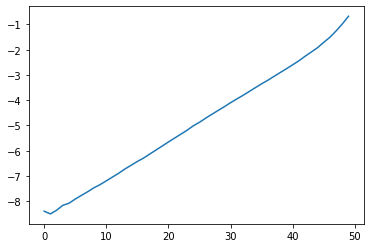

In [62]:
plt.plot(np.log(1-np.median(ps, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("Same random gate")
plt.show()

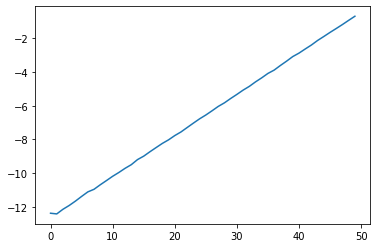

In [91]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("IID random gate")
plt.show()

In [69]:
# Fitting the exponential
from sklearn.linear_model import LinearRegression 

In [78]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))
lr.coef_[0], lr.intercept_

(0.15526394603650606, -8.72304926423791)

In [81]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))

0.9979074664890614

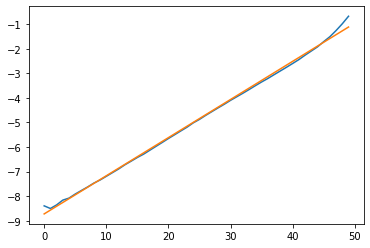

In [82]:
plt.plot(np.log(1-np.median(ps, axis=0)), label='Data')
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_, label='Linear fit')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("Same random gate")

(Recall that the 0-qubit is the closest one, so we have to reverse to measure distance).
So we have that if $o_k$ is the median overlap of the $k$-th qubit, then $-8.72304926423791 + (50-k)\cdot 0.15526394603650606 \approx \log(1-o_k)$. 
That is, 

$$1-o_k \approx e^{-0.959851962 - k\cdot 0.15526394603650606}$$

$$o_k \approx 1- e^{-0.959851962 - k\cdot 0.15526394603650606}$$

$$o_k \approx 1- 0.382949573 \cdot (1.1679662)^{-k}$$


In [92]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))
lr.coef_[0], lr.intercept_

(0.2434308164409914, -12.619907669096829)

In [93]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))

0.9998703388860332

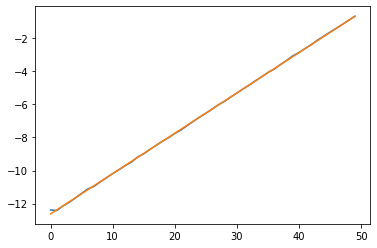

In [94]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)), label='Data')
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_, label='Linear fit')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("IID random gate")

(Recall that the 0-qubit is the closest one, so we have to reverse to measure distance).
So we have that if $o_k$ is the median overlap of the $k$-th qubit, then $-12.619907669096829 + (50-k)\cdot 0.2434308164409914 \approx \log(1-o_k)$. 
That is, 
$$1-o_k \approx e^{-0.448366847 - k\cdot 0.2434308164409914}$$

$$o_k \approx 1- e^{-0.448366847 - k\cdot 0.2434308164409914}$$

$$o_k \approx 1- 0.638670347\cdot (1.27561806)^{-k}$$
